In [1]:
#一、导入相关库
#导入库
import paddle
import paddle.fluid as fluid
import numpy as np
import sys,os,math
import paddle.fluid.layers as F
import matplotlib.pylab as plt 
from PIL import Image

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [5]:
# 修改后的自编码器模型
class AutoEncoder(fluid.dygraph.Layer):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # 编码器部分：增加隐层数量
        self.encoder_fc1 = fluid.dygraph.Linear(784, 256, act='sigmoid')  # 第一层隐层，784 -> 256
        self.encoder_fc2 = fluid.dygraph.Linear(256, 128, act='sigmoid')  # 第二层隐层，256 -> 128
        self.encoder_fc3 = fluid.dygraph.Linear(128, 64, act='sigmoid')   # 第三层隐层，128 -> 64

        # 解码器部分：增加隐层数量
        self.decoder_fc1 = fluid.dygraph.Linear(64, 128, act='sigmoid')   # 第一层隐层，64 -> 128
        self.decoder_fc2 = fluid.dygraph.Linear(128, 256, act='sigmoid')  # 第二层隐层，128 -> 256
        self.decoder_fc3 = fluid.dygraph.Linear(256, 784, act='sigmoid')  # 第三层隐层，256 -> 784

    def loss(self, x, label):
        '''
        Args：
            label：原始图像
            x：解码之后的图像
        Return:
            原始图像和解码图像之间的欧式距离
        '''
        return F.square(x - label)

    def forward(self, x):
        self.input_imgs = x
        # 编码过程
        x = self.encoder_fc1(x)
        x = self.encoder_fc2(x)
        x = self.encoder_fc3(x)
        # 解码过程
        x = self.decoder_fc1(x)
        x = self.decoder_fc2(x)
        x = self.decoder_fc3(x)
        return x

In [6]:
#三、可视化
def show_array2img(array,title):
    rebuilded_img = Image.fromarray(array.astype('uint8')).convert('RGB')
    plt.imshow(rebuilded_img)
    plt.title(title)
    plt.show()

def draw_train_process(iters,loss):
    '''
    训练可视化
    '''
    plt.title('training',fontsize=24)
    plt.xlabel('iters',fontsize=20)
    plt.ylabel('loss',fontsize=20)
    plt.plot(iters,loss,color='green',label='loss')
    plt.legend()
    plt.grid()
    plt.show()

def fix_value(img_pixs):#像素拉伸
        '''
        img_pixs:featuremap的像素矩阵
        '''
        pix_max=np.max(img_pixs)#取最大像素
        pix_min=np.min(img_pixs)#取最小像素
        pix_range=np.abs(pix_max)+np.abs(pix_min)#获取像素距离
        if(pix_range==0): #如果所有值都是零则直接返回（下面不能除以零）
            return img_pixs
        pix_rate = 255/pix_range#获取像素缩放倍率
        pix_left = pix_min*pix_rate#获取最小还原像素值
        img_pixs = img_pixs*pix_rate-pix_left#整体像素值平移
        img_pixs[np.where(img_pixs<0)]=0. #增加鲁棒性，检查超出区间的像素值，np.where(a<x)与a<x等同
        img_pixs[np.where(img_pixs>255)]=255.
        return img_pixs

start training 


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
API "paddle.dataset.mnist.train" is deprecated since 2.0.0, and will be removed in future versions. Please use "paddle.vision.datasets.MNIST" instead.
reason: Please use new dataset API which supports paddle.io.DataLoader 
  # Remove the CWD from sys.path while we load stuff.


pass_epoch:4999,iters:5000,loss：0.06593746691942215
pass_epoch:9999,iters:10000,loss：0.06399068981409073
pass_epoch:14999,iters:15000,loss：0.052999161183834076
pass_epoch:19999,iters:20000,loss：0.0471496619284153
pass_epoch:24999,iters:25000,loss：0.041735924780368805
pass_epoch:29999,iters:30000,loss：0.033881574869155884
pass_epoch:34999,iters:35000,loss：0.027645524591207504
pass_epoch:39999,iters:40000,loss：0.02133571170270443
finished training


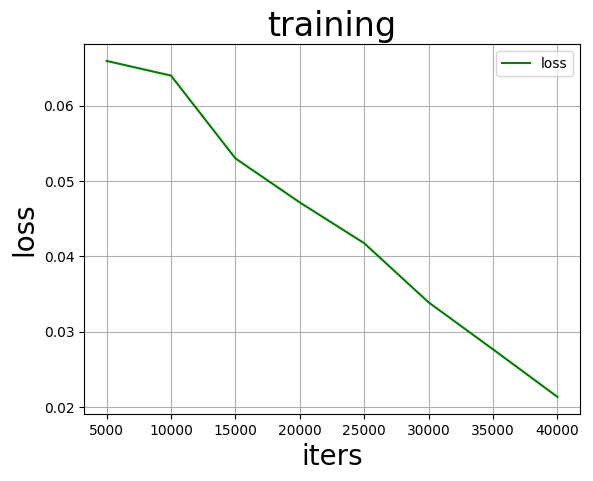

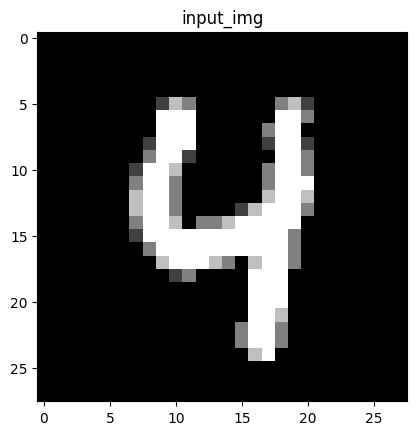

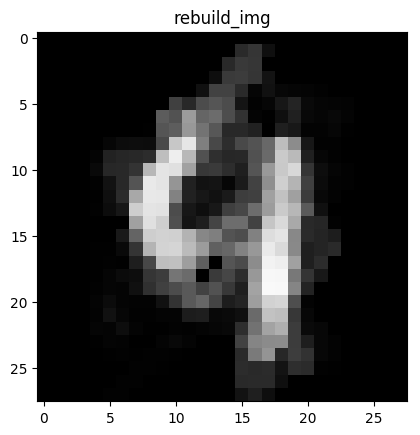

In [7]:
#四、训练模型
train_params = {
    'save_model_name':'Autoconder',
    'epoch_num':40000,
    'batch_size':32,
}

with fluid.dygraph.guard():
    print('start training ')
    train_reader = paddle.batch(reader=paddle.reader.shuffle(paddle.dataset.mnist.train(),buf_size=512),batch_size=train_params['batch_size'])     
    
    #读取一组32x784的输入，每次迭代都用这一个输入
    for i,data in enumerate(train_reader()):
        temp_images = []
        for i in range(32):
            temp_images.append(np.reshape(data[i][0],(784)))
        temp_images=fluid.dygraph.to_variable(np.asarray(temp_images).reshape((32,784)))
        temp_images= (temp_images+1)/2  #原来的数据区间是[-1,1]这里把它调整到[0,1]
        break
    model = AutoEncoder()  #实列化模型
    model.train()
    all_iter = 0
    all_loss = []
    all_iters = []
    all_accs = []
    opt=fluid.optimizer.AdamOptimizer(learning_rate=0.00001,parameter_list=model.parameters())
    for pass_num in range(train_params['epoch_num']):
        predict = model(temp_images)
        avg_loss= F.mean(model.loss(predict,temp_images))
        avg_loss.backward()
        opt.minimize(avg_loss)
        opt.clear_gradients()
        all_iter+=1
        if all_iter%5000==0:
            all_loss.append(avg_loss.numpy()[0])
            all_iters.append(all_iter)
            print('pass_epoch:{},iters:{},loss：{}'.format(pass_num,all_iter,avg_loss.numpy()[0]))
    fluid.save_dygraph(model.state_dict(),train_params['save_model_name']) #保存模型参数
    
    print('finished training')
    
    # 打印训练过程中loss变化情况
    draw_train_process(all_iters,all_loss)

    # 可视化测试AutoEncoder对MNIST数据的重构效果
    predict = fix_value(predict.numpy())
    #print (type(model.input_imgs))
    input_imgs = fix_value(model.input_imgs.numpy())
    for i in range(1):
        show_array2img(np.reshape(input_imgs[i],(28,28)),'input_img')
        show_array2img(np.asarray(np.reshape(predict[i],(28,28))),'rebuild_img')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 